In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.svm import SVC
import seaborn as sns
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

### Read Datasets

In [2]:
path = r"D:\AAAAAAA\NLP Course\NLP-Project\DataSets\testdata.manual.2009.06.14.csv"

df = pd.read_csv(path , encoding="ISO-8859-1" , names=["target" , "id" , "date" , "flags" , "user" , "text"])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [3]:
df.shape

(498, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [5]:
pd.DataFrame(df["target"].value_counts())

,count
target,
4,182
0,177
2,139


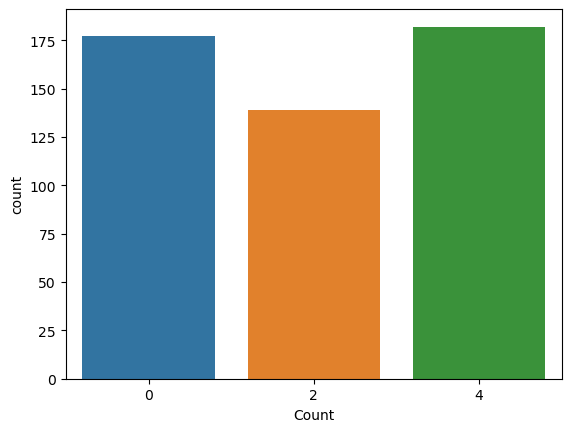

In [6]:
sns.countplot(data=df , x="target")
plt.xlabel("Target" )
plt.xlabel("Count" )
plt.show()

In [7]:
df["target"].value_counts(normalize=True)

target
4    0.365462
0    0.355422
2    0.279116
Name: proportion, dtype: float64

In [8]:
df = df[["target" , "text"]]
df

,target,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


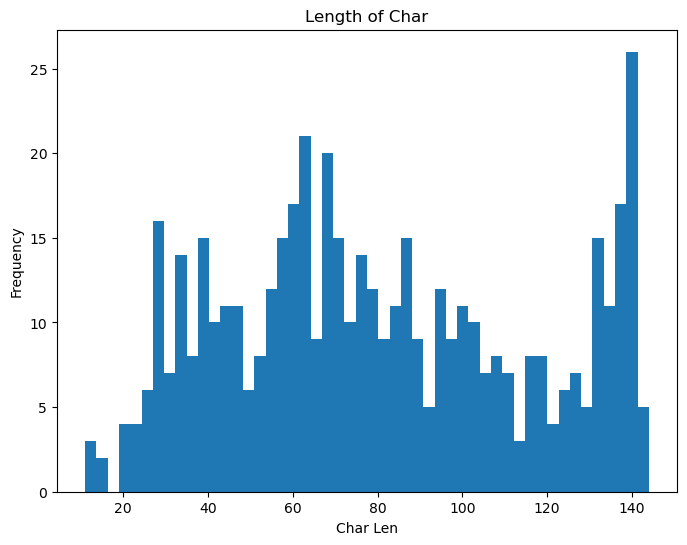

In [9]:
len_char = df["text"].str.len()

plt.figure(figsize=(8,6))
plt.hist(len_char , bins=50)
plt.title("Length of Char")
plt.xlabel("Char Len")
plt.ylabel("Frequency")
plt.show()

##### For Example "I love #Python and #AI" return: ['Python', 'AI']

In [10]:
# Hashtags
def hashtag_extract(x):
    hashtags = []

    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


# Extracting hashtags for each class
hash_neg = hashtag_extract(df[df['target']==0]['text'])  # Negative Hashtags
hash_neu = hashtag_extract(df[df['target']==2]['text'])  # Neutral Hashtags
hash_pos = hashtag_extract(df[df['target']==4]['text'])  # Positive Hashtags

# Unnesting the lists
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

In [11]:
hash_pos

['kindle2',
 'lebron',
 'ttiv',
 'MLUC09',
 'mostvaluablepuppets',
 'googleio',
 'webdesign',
 'io2009',
 'googleio',
 'GoogleIO',
 'io2009',
 'wave',
 'Kindle2']

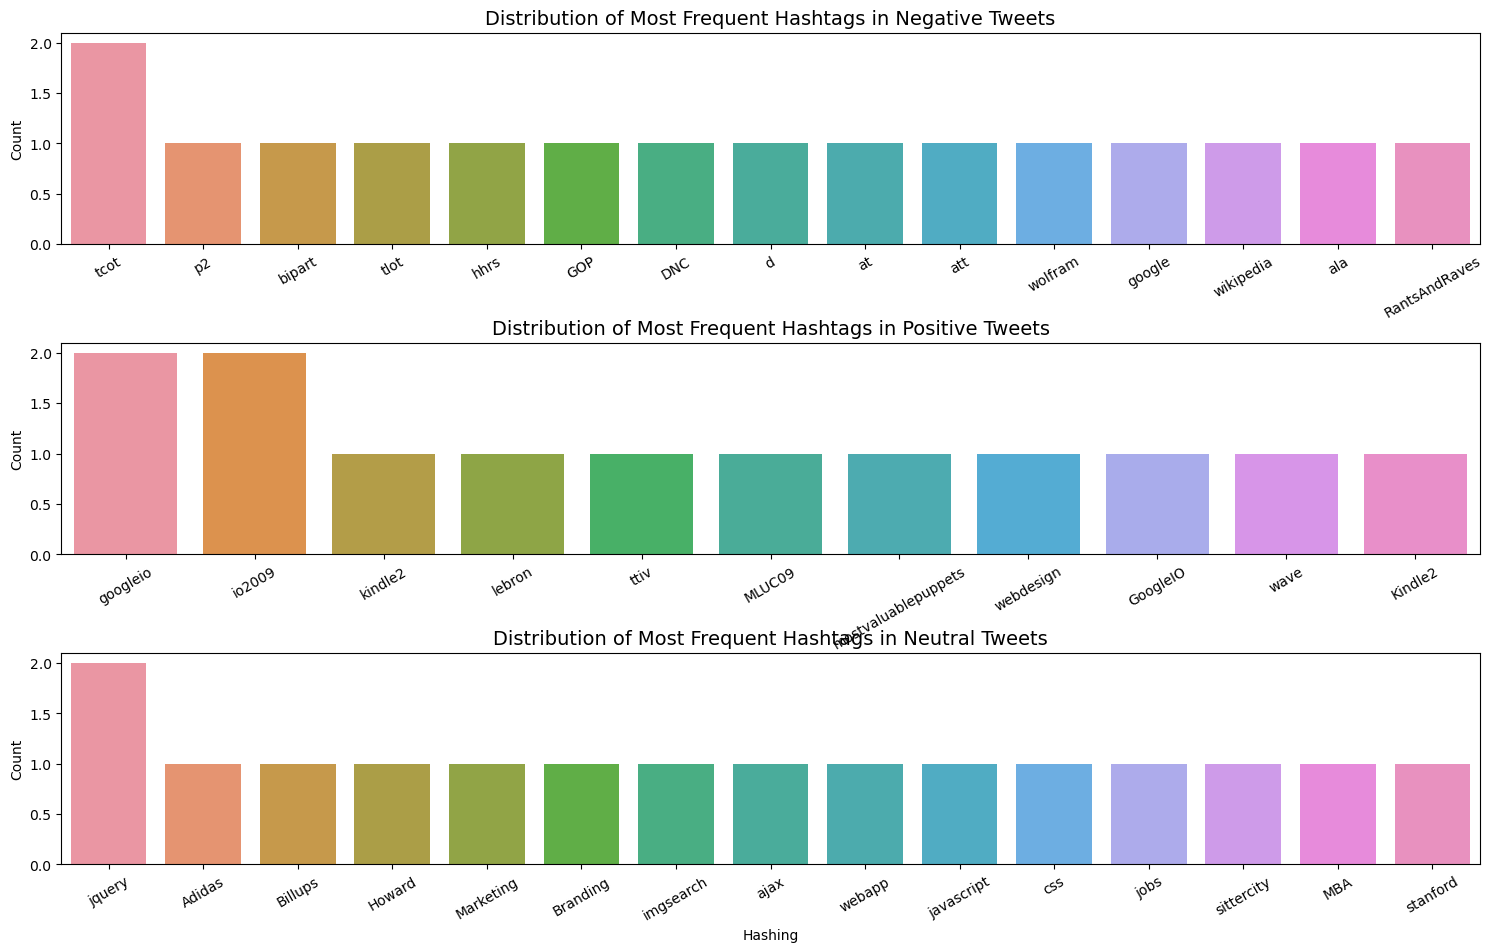

In [12]:
# Create frequency distributions
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)
a_neu = nltk.FreqDist(hash_neu)

# Convert to DataFrames
df_neg = pd.DataFrame({"Hashing": list(a_neg.keys()), 
                       "Count": list(a_neg.values())})

df_pos = pd.DataFrame({"Hashing": list(a_pos.keys()), 
                       "Count": list(a_pos.values())})

df_neu = pd.DataFrame({"Hashing": list(a_neu.keys()), 
                       "Count": list(a_neu.values())})

# Get the top 15 most frequent hashtags
df_neg = df_neg.nlargest(columns="Count", n=15)
df_pos = df_pos.nlargest(columns="Count", n=15)
df_neu = df_neu.nlargest(columns="Count", n=15)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)

# Negative Tweets
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashing', y='Count')  
plt.xticks(rotation=30)
plt.title('Distribution of Most Frequent Hashtags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')

# Positive Tweets
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashing', y='Count') 
plt.xticks(rotation=30)
plt.title('Distribution of Most Frequent Hashtags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')

# Neutral Tweets
plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashing', y='Count')  
plt.xticks(rotation=30)
plt.title('Distribution of Most Frequent Hashtags in Neutral Tweets', fontsize=14, c='k')

plt.show()

In [13]:
def remove_patterns(input_text , pattern) :
    return re.sub(pattern , "" , input_text)


In [14]:
df.loc[:, "text"] = df["text"].apply(lambda x : remove_patterns(x , r'@[\w]*'))
df.head()

,target,text
0,4,I loooooooovvvvvveee my Kindle2. Not that the...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [15]:
# Check Before
df["text"].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [16]:
# Remove Hyberlinks
df["text"] = df["text"].apply(lambda x: remove_patterns(x, r"https?://\S+|www\.\S+"))
df.head()

,target,text
0,4,I loooooooovvvvvveee my Kindle2. Not that the...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [17]:
# After Remove Hyberlinks
df["text"].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] '

## Remove Rpeated Chars

In [18]:
df["text"][0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [19]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
df.loc[:, 'text'] = df['text'].apply(remove_excessive_repeated_characters)
df.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [20]:
df["text"][0]

' I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

## Emostions

In [21]:
# Check Before
df["text"].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! :)'

In [22]:
# Convert Emojis to Text : example 😀 to Happy , 😢 Sad
# This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
# So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


def covert_emostion(text : str) :
    for emotion , meaning in emoticon_meanings.items() :
        text = text.replace(emotion , meaning)

    return text

df.loc[:, 'text'] = df['text'].apply(covert_emostion)
df.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [23]:
# Check After
df["text"].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! Happy'

* `Remove Punctuatiosn, Numbers, Special Chars`

In [24]:
# Removing Punctuations, Numbers, and Special Characters
df.loc[:, 'text'] = df['text'].str.replace('[^a-zA-Z#]', ' ', regex=True)
df.head()

,target,text
0,4,I love my Kindle Not that the DX is cool b...
1,4,Reading my kindle Love it Lee childs i...
2,4,Ok first assesment of the #kindle it fuck...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


* `Removing short words`

In [25]:
# Removing Short Words
df.loc[:, 'text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [26]:
df.iloc[0]["text"].split()

['love', 'Kindle', 'that', 'cool', 'fantastic', 'right']

* `Remove Numbers from Words`

In [27]:
# Removing Numbers From Words 
df.loc[:, 'text'] = df['text'].apply(lambda x: remove_patterns(x , '(?<=\w)\d+|\d+(?=\w)'))
df.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


* `Remove Special Chars`

In [28]:
# Removing Special Chars 
df.loc[:, 'text'] = df['text'].apply(lambda x: remove_patterns(x , r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
df.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [29]:
# An exmaple before removing special chars
df['text'].iloc[2]

'first assesment kindle fucking rocks'

In [30]:
# An exmaple before solving that
df['text'].iloc[3]

'love your Kindle mine months never looked back huge need remorse Happy'

* `Rmeove Redundant words`

In [31]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text : str) :
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub("" , text)

    stop_words = set(stopwords.words("english"))

    words = text.split()
    filtered_words = [w for w in words if w.lower() not in stop_words]
    clean_text = " ".join(filtered_words)

    clean_text = " ".join(clean_text.split())

    return clean_text


# Apply the above function
df.loc[:, 'text'] = df['text'].apply(remove_redundant_words_extra_spaces)
df.head(10)

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love Kindle mine months never looked back huge...
4,4,Fair enough Kindle think perfect Happy
5,4,quite happy Kindle
6,0,Fuck economy hate loan given asses
7,4,Jquery best friend
8,4,Loves twitter
9,4,love Obama makes jokes


In [32]:
# An exmaple before solving that
df['text'].iloc[3]

'love Kindle mine months never looked back huge need remorse Happy'

In [33]:
# make folder for cleaned data 
clean_df_folder  = os.path.join(os.getcwd() , "cleaned_datasets")
os.makedirs(clean_df_folder , exist_ok=True)


In [34]:
# Download the dataset here at this step before Lemmatizing
df.to_csv(os.path.join(clean_df_folder, "cleaned_datasets_1.csv"), index=False)

* `Tokenization`

In [35]:
# word Tokenization
Tokenization_chars = df["text"].apply(lambda x : word_tokenize(x))
Tokenization_chars.head()

0               [love, Kindle, cool, fantastic, right]
1          [Reading, kindle, Love, childs, good, read]
2           [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, ba...
4        [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [36]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply Lemmatization
tokenized_tweet = Tokenization_chars.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

# Join words
df.loc[:, 'text'] = tokenized_tweet.apply(lambda x: ' '.join(x))

df.head()

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge ...
4,4,Fair enough Kindle think perfect Happy


* `Some Viz`

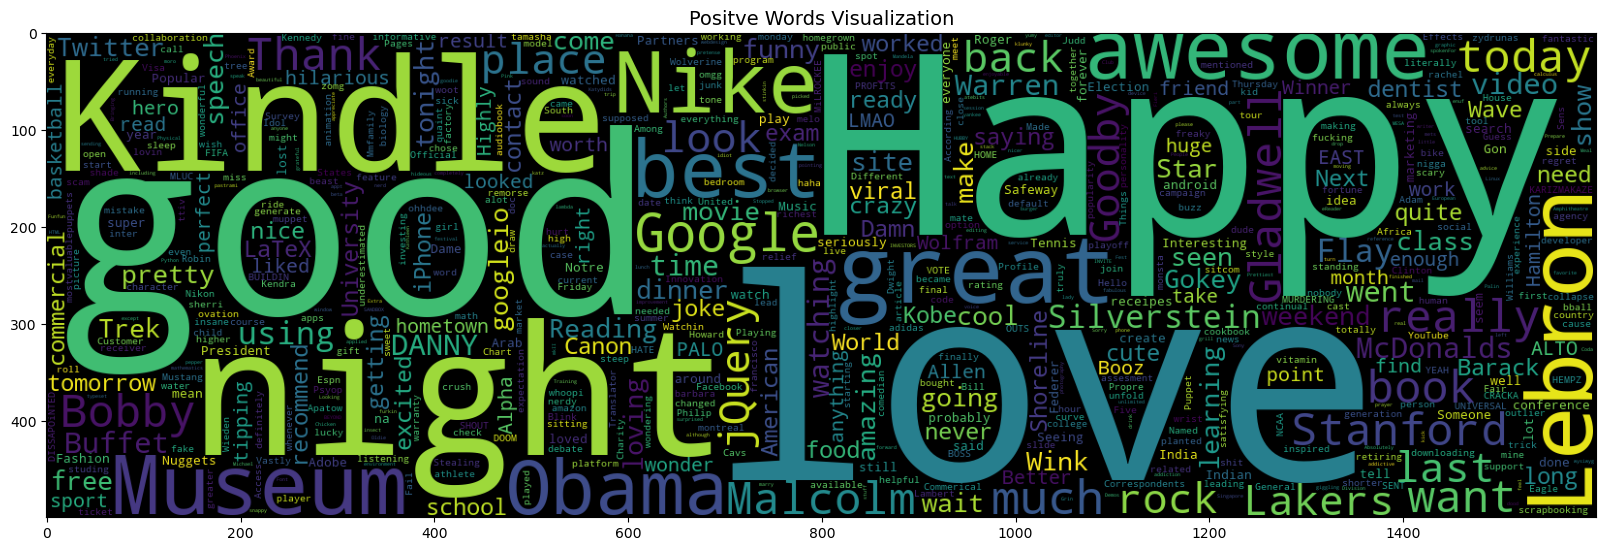

In [37]:
## For Positive Words
plt.figure(figsize=(20,8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(df[df['target']==4]['text'].astype(str)))

plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

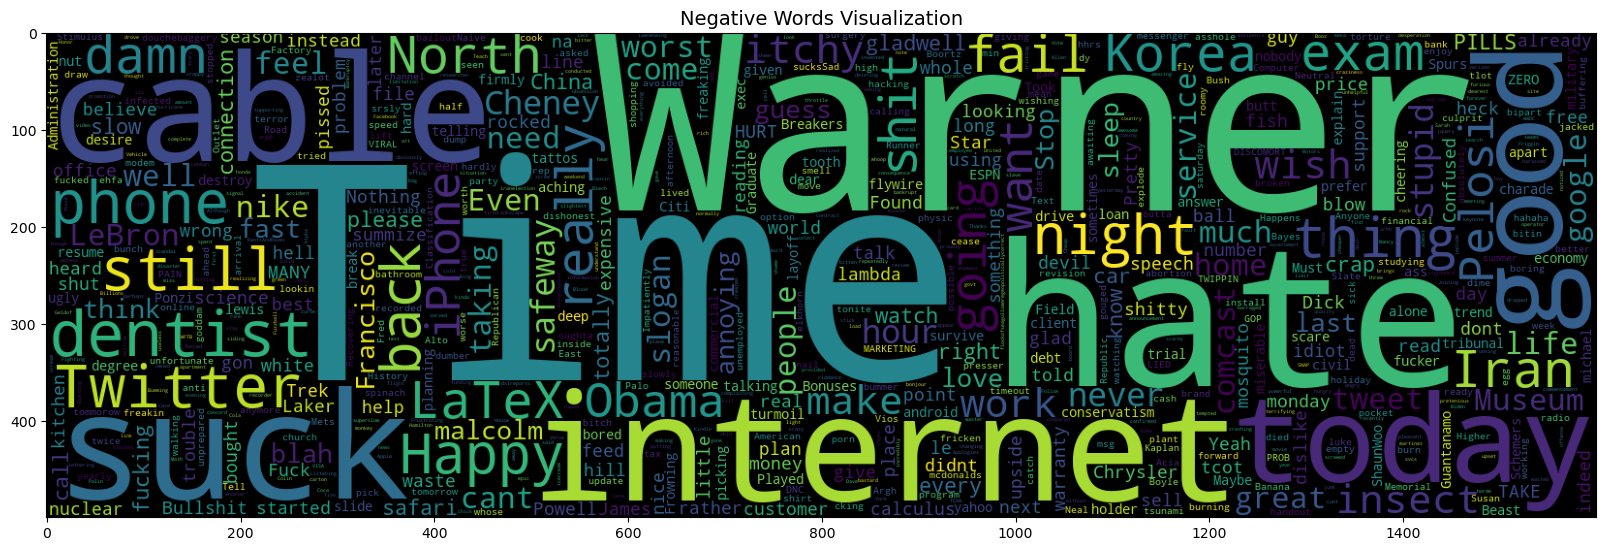

In [38]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(df[df['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

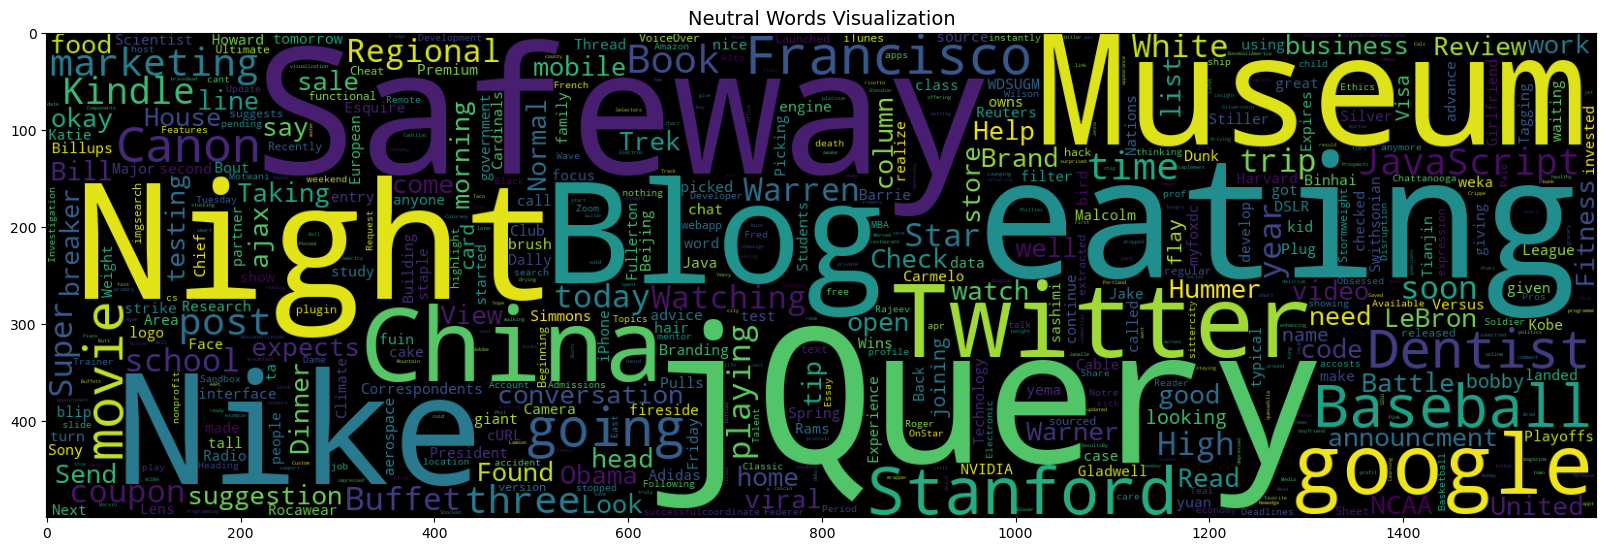

In [39]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(df[df['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

* `Text Representation`

* `BOW`

In [40]:
bow = CountVectorizer(max_df=0.90 , min_df=2 , max_features=None , stop_words="english")
x_bow = bow.fit_transform(df["text"])
x_bow = x_bow.toarray()
x_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# artifacts folder path
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [42]:
# dump the bow_vectorizer
joblib.dump(bow, os.path.join(ARTIFACTS_FOLDER_PATH, 'bow_vectorizer.pkl'))

['d:\\AAAAAAA\\NLP Course\\NLP-Project\\NoteBooks\\..\\artifacts\\bow_vectorizer.pkl']

`2. TF-IDF`

In [43]:
tfidf = CountVectorizer(max_df=0.90 , min_df=2 , max_features=None , stop_words="english")
x_tfidf = tfidf.fit_transform(df["text"])
x_tfidf = x_tfidf.toarray()
x_tfidf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

`4. FastText`

In [44]:
# Tokenize text data

token_sent = [i.split() for i in df["text"]]

w2vec = Word2Vec(
    sentences=token_sent , 
    vector_size=300 , 
    window=5 , 
    min_count=1 , 
    sg=1 , 
    epochs=20 , 
    workers=4 
)

w2vec.save(os.path.join(ARTIFACTS_FOLDER_PATH , "w2vec_custom.model"))

In [45]:
def sentence_to_vector(sentence) :
    words = sentence.split()
    word_vectors = [w2vec.wv[w] for w in words if w in w2vec.wv]

    if len(word_vectors) == 0 :
        return np.zeros(300)
    
    return np.mean(word_vectors , axis=0)


x_w2vec_custom = np.array([
    sentence_to_vector(text) for text in df["text"]
])

x_w2vec_custom

array([[-0.00421202,  0.02208007,  0.01068351, ..., -0.01852917,
         0.01937182,  0.00401483],
       [-0.00359366,  0.02192298,  0.0105875 , ..., -0.01715097,
         0.01702999,  0.00210982],
       [-0.0022349 ,  0.01257649,  0.00376644, ..., -0.00836313,
         0.01036891,  0.00114332],
       ...,
       [-0.00461491,  0.0204936 ,  0.00956497, ..., -0.01755497,
         0.01620259,  0.00240613],
       [-0.00103337,  0.02474842,  0.00976027, ..., -0.01743881,
         0.01812684,  0.00346034],
       [-0.00179959,  0.01697357,  0.0065557 , ..., -0.01364186,
         0.01171536,  0.00289417]], dtype=float32)

`5. GloVe Twitter`

In [46]:
# Load pre-trained model
glove_twitter_model = api.load("glove-twitter-25")


In [47]:
def sentence_to_vector_pretrained(sentence) :
    words = sentence.lower().split()
    word_vectors = [glove_twitter_model[w] for w in words if w in glove_twitter_model]

    if len(word_vectors) == 0 :
        return np.zeros(25)
    
    return np.mean(word_vectors , axis=0)


sentence_to_vector_pretrained = np.array([
    sentence_to_vector_pretrained(text) for text in df["text"]
])

sentence_to_vector_pretrained.shape

(498, 25)

* `Split The dataset`

In [48]:
dict_map = {0: 0, 4: 1, 2: 2}    # 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v: k for k, v in dict_map.items()}

# Apply that to the dataset
df.loc[:, 'target'] = df['target'].map(dict_map)
df['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [49]:
def prepare_data(method = "BOW") :
    if method.lower() == "bow" :
        X = x_bow

    elif method.lower() == "tfidf" :
        X = x_tfidf

    elif method.lower() == "word2vec" :
        X = x_w2vec_custom

    elif method.lower() == "glove_twitter" :
        X = sentence_to_vector_pretrained

    else :
        raise ValueError("Enter A Valid Method From (BOW , TFIDF , W2Vec , Glove Twitter)")
    

    y = df["target"]

    over = SMOTE()

    X_new , y_new = over.fit_resample(X , y)

    X_train , X_test , y_train , y_test = train_test_split(X_new , y_new , test_size=0.2 , random_state=15 , stratify=y_new)

    return X_train , X_test , y_train , y_test


* `Building Models`

* `SVM`

In [50]:
def svm_model(method: str): 

    X_train, X_test, y_train, y_test = prepare_data(method=method)
    
    svc = SVC(C=0.98, kernel='rbf', gamma=0.15, random_state=42)
    svc.fit(X_train, y_train)
    
    # Accuracy
    y_pred_train_svc = svc.predict(X_train)
    y_pred_test_svc = svc.predict(X_test)
    
    acc_train_svc = round(100*accuracy_score(y_train, y_pred_train_svc), 4)
    acc_test_svc = round(100*accuracy_score(y_test, y_pred_test_svc), 4)
    
    return svc, acc_train_svc, acc_test_svc

In [51]:
# BOW with SVM
svc_bow, acc_train_svm_bow, acc_test_svm_bow = svm_model(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using SVM:\t {acc_train_svm_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using SVM: \t {acc_test_svm_bow} %')

Accuracy Score for Training Dataset using BOW using SVM:	 88.0734 %
Accuracy Score for Testing Dataset using BOW using SVM: 	 74.5455 %


In [52]:
# Using TFIDF with SVM
svc_tfidf, acc_train_svm_tfidf, acc_test_svm_tfidf = svm_model(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using SVM:\t {acc_train_svm_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using SVM:\t {acc_test_svm_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using SVM:	 87.3853 %
Accuracy Score for Testing Dataset using TFIDF using SVM:	 74.5455 %


In [53]:
# Using Glove with SVM
svc_glove, acc_train_svm_w2vec, acc_test_svm_w2vec = svm_model(method='word2vec')
print(f'Accuracy Score for Training Dataset using Word2vec using SVM:\t {acc_train_svm_w2vec} %')
print(f'Accuracy Score for Testing Dataset using Word2vec using SVM:\t {acc_test_svm_w2vec} %')

Accuracy Score for Training Dataset using Word2vec using SVM:	 33.7156 %
Accuracy Score for Testing Dataset using Word2vec using SVM:	 33.6364 %


In [54]:
# Using GloVe with SVM
svc_glove, acc_train_svm_glove_twitter, acc_test_svm_glove_twitter = svm_model(method='glove_twitter')
print(f'Accuracy Score for Training Dataset using GloVeTwitter using SVM:\t {acc_train_svm_glove_twitter} %')
print(f'Accuracy Score for Testing Dataset using GloVeTwitter using SVM:\t {acc_test_svm_glove_twitter} %')

Accuracy Score for Training Dataset using GloVeTwitter using SVM:	 80.7339 %
Accuracy Score for Testing Dataset using GloVeTwitter using SVM:	 73.6364 %


In [55]:
# Combine all results of SVM wihtout Jaya in one DataFrame
acc_train_svm = [acc_train_svm_bow, acc_train_svm_tfidf, 
                acc_train_svm_w2vec, acc_train_svm_glove_twitter]
acc_test_svm = [acc_test_svm_bow, acc_test_svm_tfidf, 
                acc_test_svm_w2vec, acc_test_svm_glove_twitter]


# Create a DataFrame for SVM accuracies
data_svm = {
        'vect_method': ['BOW', 'TF-IDF', "Word2Vec", "GloVe-Twitter"],
        'train_acc': acc_train_svm,
        'test_acc': acc_test_svm
            }

svm_accuracy_df = pd.DataFrame(data_svm).sort_values(by="test_acc", ascending=False)
svm_accuracy_df

,vect_method,train_acc,test_acc
0,BOW,88.0734,74.5455
1,TF-IDF,87.3853,74.5455
3,GloVe-Twitter,80.7339,73.6364
2,Word2Vec,33.7156,33.6364


In [56]:
# dump model
joblib.dump(svc_bow, os.path.join(ARTIFACTS_FOLDER_PATH, 'svm_bow.pkl'))

['d:\\AAAAAAA\\NLP Course\\NLP-Project\\NoteBooks\\..\\artifacts\\svm_bow.pkl']

In [62]:
# dump model
joblib.dump(svc_glove, os.path.join(ARTIFACTS_FOLDER_PATH, 'svc_glove_twitter.pkl'))

['d:\\AAAAAAA\\NLP Course\\NLP-Project\\NoteBooks\\..\\artifacts\\svc_glove_twitter.pkl']

# END 